In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using Polynomials

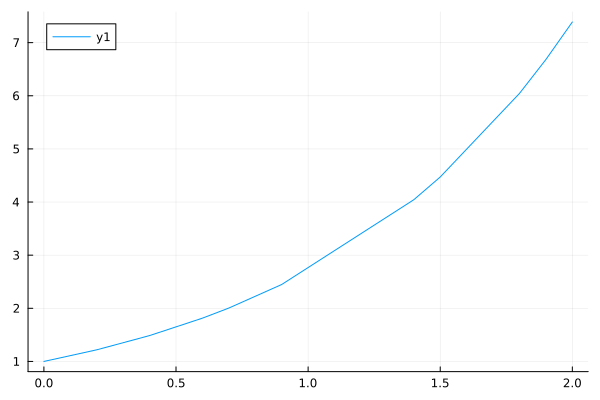

In [2]:
function BVP1D(c::Float64, d::Float64, x::Vector{Float64}) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        k1 = 1/h + h/3
        k2 = -1/h + h/6

        A[i, i] += k1
        A[i, i+1] = k2
        A[i+1, i] = k2
        A[i+1, i+1] = k1
    end

    
    # Algorithm 2
    b[1] = c
    b[2] -= A[1,2] * c
    b[M-1] -= A[M-1,M] * d
    b[M] = d
    
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

c = 1.0
d = exp(2)
x = [0.0, 0.2, 0.4, 0.6, 0.7, 0.9, 1.4, 1.5, 1.8, 1.9, 2.0]
u = BVP1D(c, d, x)
plot(x, u)

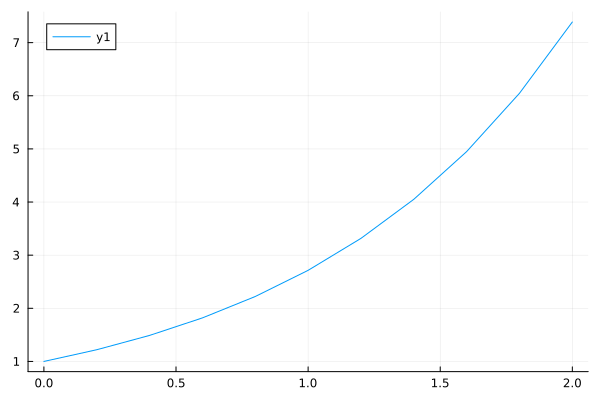

In [3]:
function BVP1D(c::Float64, d::Float64, L::Float64, M::UInt64) :: Tuple{Vector{Float64}, Vector{Float64}}
    x = collect(range(0, L, M))
    u = BVP1D(c, d, x)
    return u, x
end

c = 1.0
d = exp(2)
L = 2.0
M::UInt64 = 11

u, x = BVP1D(c, d, L, M)
plot(x, u)

2.0006860815877427

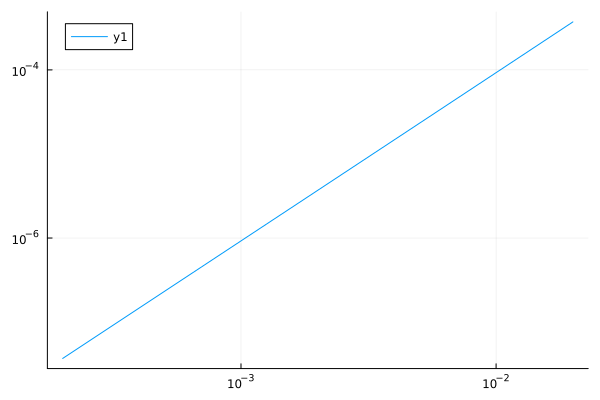

In [5]:
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end

x_values = collect(range(0, stop=L, length=1000000))
N = 100
hs = zeros(N)
max_errors = zeros(N)
for i in 1:N
    M = i*N
    u_coefs, x_points = BVP1D(c,d,L,M)
    errors = abs.(exp.(x_values)-uhat(x_values,x_points,u_coefs))
    hs[i] = L/M
    max_errors[i] = maximum(errors)
end

coefficients = fit(log.(hs), log.(max_errors), 1)[1]
print(coefficients)
plot(hs ,max_errors, xscale=:log10, yscale=:log10)